# 시계열 예측

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True
)
csv_path, _ = os.path.splitext(zip_path)

df = pd.read_csv(csv_path)
df = df[5::6]
df.describe().transpose()

13568290/13568290 [==============================] - 2s 0us/step


,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


# 데이터 전처리


In [3]:
# Wind
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')
wd_rad = df.pop('wd (deg)')*np.pi / 180

df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

In [4]:
# Time
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

In [5]:
# Train, Valid, Test
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [6]:
# Data normalization
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

# 데이터 윈도우 생성


In [7]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift
    self.total_window_size = input_width + shift
    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [8]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

## 플롯

In [9]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

# 데이터셋 만들기

In [10]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)
  ds = ds.map(self.split_window)
  return ds

WindowGenerator.make_dataset = make_dataset

In [11]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

# 다중 스텝 예측 모델


Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['T (degC)']

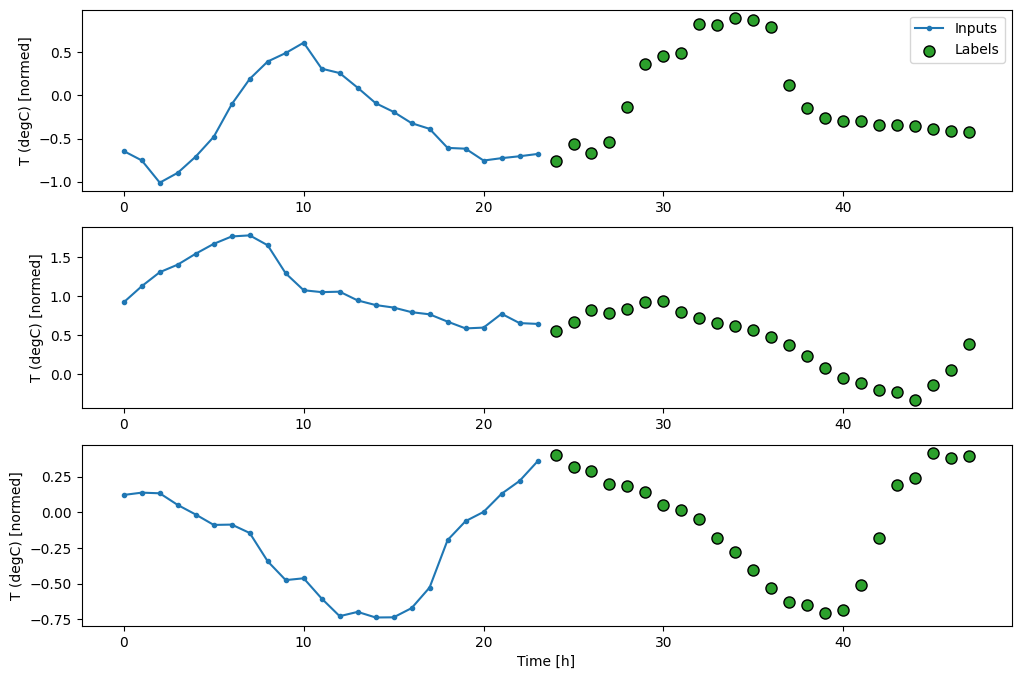

In [13]:
# Past 24 hours => Future 24 hours
multi_window = WindowGenerator(input_width=24, label_width=24, shift=24, label_columns=['T (degC)'])
multi_window.plot()
multi_window

# Naive baselines

In [ ]:
multi_performance = {}

dict_items([('Maintain', [0.28136250376701355, 0.39707449078559875])])

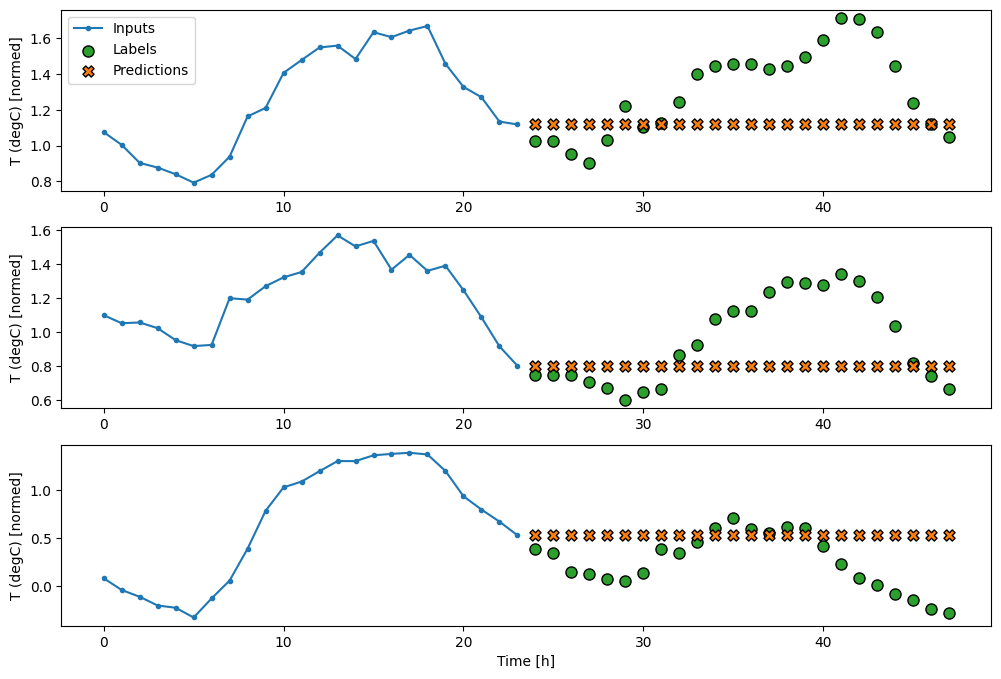

In [ ]:
class MaintainBaseline(tf.keras.Model):
  def __init__(self, label_index):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    return tf.tile(inputs[:, -1:, self.label_index], [1, 24])

maintain_baseline = MaintainBaseline(label_index=column_indices['T (degC)'])
maintain_baseline.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

multi_performance['Maintain'] = maintain_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(maintain_baseline)
multi_performance.items()

dict_items([('Maintain', [0.28136250376701355, 0.39707449078559875]), ('Repeat', [0.1274913102388382, 0.27453362941741943])])

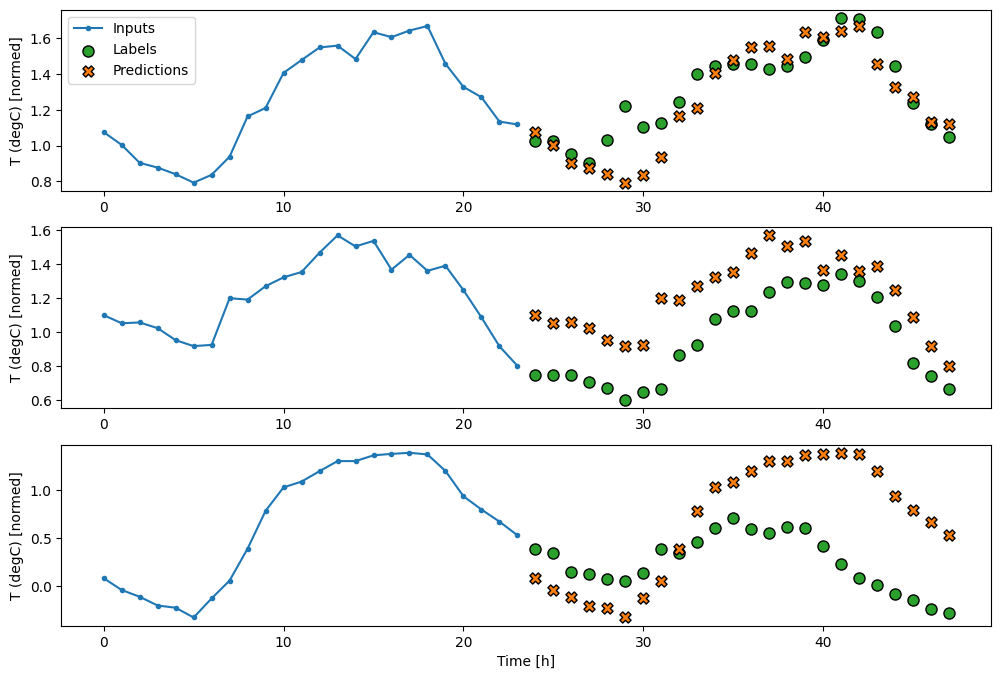

In [ ]:
class RepeatBaseline(tf.keras.Model):
  def __init__(self, label_index):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    return inputs[:, :, self.label_index]

repeat_baseline = RepeatBaseline(label_index=column_indices['T (degC)'])
repeat_baseline.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)
multi_performance.items()

# CNN

In [ ]:
def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss',
      patience=patience,
      mode='min'
  )
  model.compile(
      loss=tf.keras.losses.MeanSquaredError(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=[tf.keras.metrics.MeanAbsoluteError()]
  )
  history = model.fit(
      window.train, epochs=20,
      validation_data=window.val,
      callbacks=[early_stopping]
  )
  return history

In [ ]:
f, k, out_steps = 256, 3, 24

multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -k:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(filters = f, kernel_size = (k), activation='relu'),
    # Shape => [batch, 1, out_steps]
    tf.keras.layers.Dense(out_steps, kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, 1]
    tf.keras.layers.Reshape([out_steps, 1])
])

multi_conv_model.build((32, 24, 19)) # [batch, time, features]
multi_conv_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_8 (Lambda)           (32, 3, 19)               0         
                                                                 
 conv1d_8 (Conv1D)           (32, 1, 256)              14848     
                                                                 
 dense_9 (Dense)             (32, 1, 24)               6168      
                                                                 
 reshape_9 (Reshape)         (32, 24, 1)               0         
                                                                 
Total params: 21,016
Trainable params: 21,016
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
1532/1532 [==============================] - 12s 7ms/step - loss: 0.0952 - mean_absolute_error: 0.2309 - val_loss: 0.0819 - val_mean_absolute_error: 0.2148
Epoch 2/20
1532/1532 [==============================] - 11s 7ms/step - loss: 0.0821 - mean_absolute_error: 0.2162 - val_loss: 0.0806 - val_mean_absolute_error: 0.2133
Epoch 3/20
1532/1532 [==============================] - 12s 8ms/step - loss: 0.0786 - mean_absolute_error: 0.2111 - val_loss: 0.0806 - val_mean_absolute_error: 0.2128
Epoch 4/20
1532/1532 [==============================] - 12s 8ms/step - loss: 0.0766 - mean_absolute_error: 0.2079 - val_loss: 0.0780 - val_mean_absolute_error: 0.2098
Epoch 5/20
1532/1532 [==============================] - 11s 7ms/step - loss: 0.0752 - mean_absolute_error: 0.2058 - val_loss: 0.0755 - val_mean_absolute_error: 0.2055
Epoch 6/20
1532/1532 [==============================] - 11s 7ms/step - loss: 0.0740 - mean_absolute_error: 0.2041 - val_loss: 0.0768 - val_mean_absolute_error: 0.207

dict_items([('Maintain', [0.28136250376701355, 0.39707449078559875]), ('Repeat', [0.1274913102388382, 0.27453362941741943]), ('Conv', [0.06730546057224274, 0.19696548581123352])])

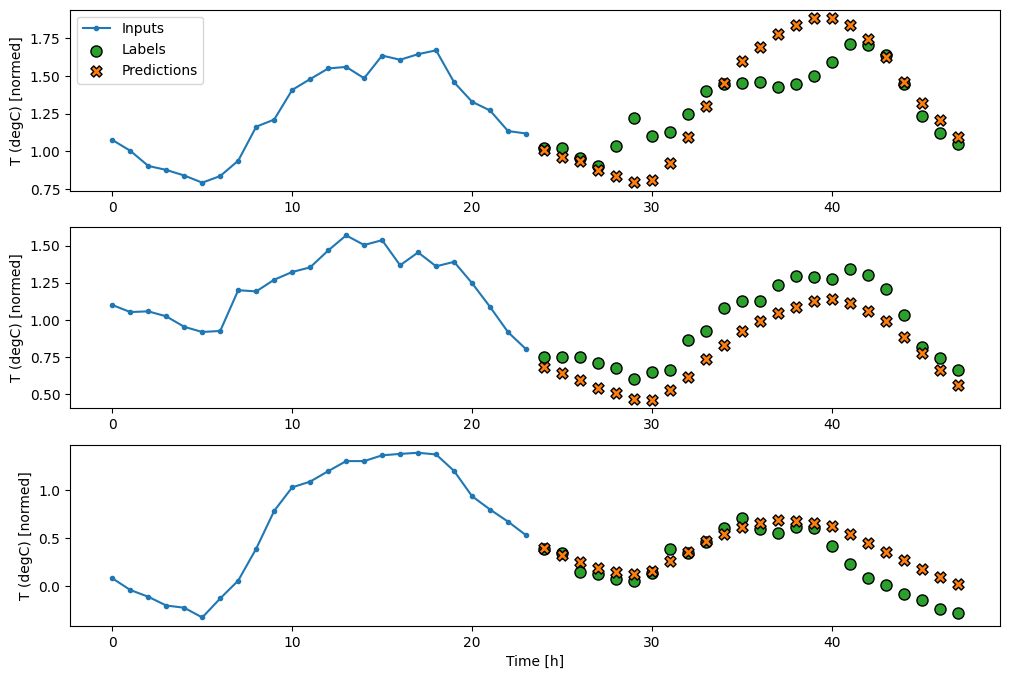

In [ ]:
history = compile_and_fit(multi_conv_model, multi_window)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)
multi_performance.items()

# RNN (long short-term memory; LSTM)

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(units=64, return_sequences=False),
    # Shape => [batch, out_steps].
    tf.keras.layers.Dense(out_steps, kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, 1].
    tf.keras.layers.Reshape([out_steps, 1])
])

multi_lstm_model.build((32, 24, 19)) # [batch, time, features]
multi_lstm_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (32, 32)                  6656      
                                                                 
 dense_10 (Dense)            (32, 24)                  792       
                                                                 
 reshape_10 (Reshape)        (32, 24, 1)               0         
                                                                 
Total params: 7,448
Trainable params: 7,448
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
1532/1532 [==============================] - 17s 10ms/step - loss: 0.1173 - mean_absolute_error: 0.2510 - val_loss: 0.0822 - val_mean_absolute_error: 0.2184
Epoch 2/20
1532/1532 [==============================] - 14s 9ms/step - loss: 0.0715 - mean_absolute_error: 0.2022 - val_loss: 0.0759 - val_mean_absolute_error: 0.2075
Epoch 3/20
1532/1532 [==============================] - 13s 9ms/step - loss: 0.0674 - mean_absolute_error: 0.1951 - val_loss: 0.0744 - val_mean_absolute_error: 0.2049
Epoch 4/20
1532/1532 [==============================] - 14s 9ms/step - loss: 0.0651 - mean_absolute_error: 0.1912 - val_loss: 0.0734 - val_mean_absolute_error: 0.2032
Epoch 5/20
1532/1532 [==============================] - 13s 8ms/step - loss: 0.0634 - mean_absolute_error: 0.1884 - val_loss: 0.0743 - val_mean_absolute_error: 0.2041
Epoch 6/20
1532/1532 [==============================] - 14s 9ms/step - loss: 0.0619 - mean_absolute_error: 0.1861 - val_loss: 0.0737 - val_mean_absolute_error: 0.20

dict_items([('Maintain', [0.28136250376701355, 0.39707449078559875]), ('Repeat', [0.1274913102388382, 0.27453362941741943]), ('Conv', [0.06730546057224274, 0.19696548581123352]), ('LSTM', [0.06444300711154938, 0.19253811240196228])])

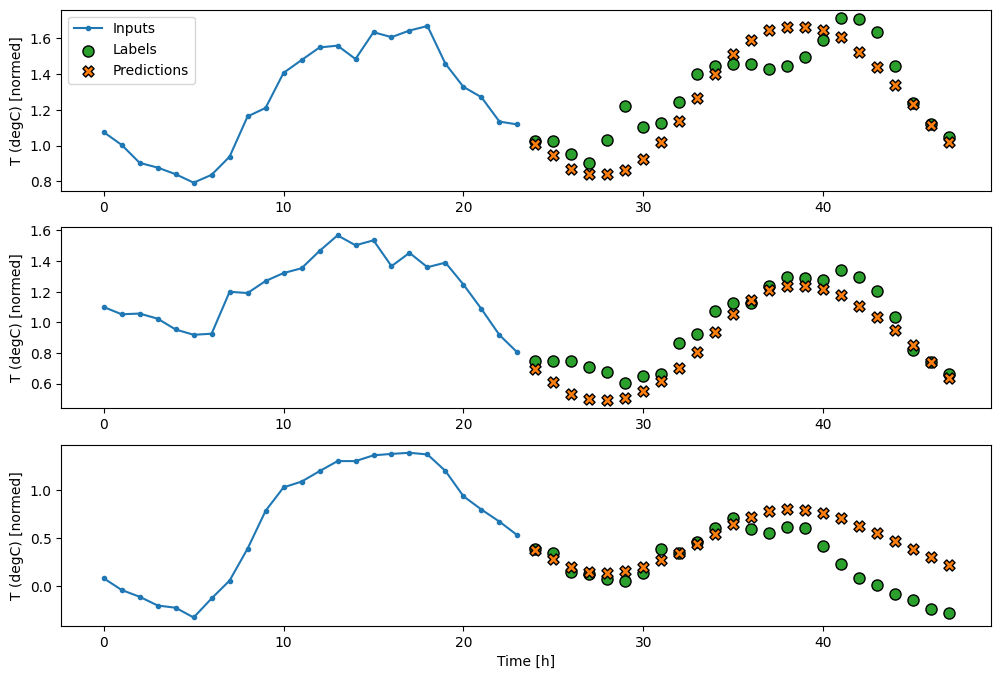

In [ ]:
history = compile_and_fit(multi_lstm_model, multi_window)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)
multi_performance.items()

In [ ]:
# Performance
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Maintain: 0.3971
Repeat  : 0.2745
Conv    : 0.1970
LSTM    : 0.1925
